# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.pipeline import make_pipeline
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import VotingClassifier


### 데이터 셋 읽어오기

In [2]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

column_to_drop = ['customer_country.1',  'ver_pro', 'business_subarea',"product_subcategory", "product_modelname", 
                  "com_reg_ver_win_rate",
                 "historical_existing_cnt",
                  "ver_win_ratio_per_bu",
                  "ver_win_rate_x",
                  "business_area","expected_timeline"]
df_train['customer_country'] = df_train['customer_country'].astype(str).apply(lambda x:x.split("/")[-1])
df_test['customer_country'] = df_test['customer_country'].astype(str).apply(lambda x:x.split("/")[-1])
df_train.drop(columns=column_to_drop, inplace=True)
df_test.drop(columns=column_to_drop, inplace=True)

# Assuming your DataFrame is named df_train
missing_values = df_train.isnull().sum()

# Display columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
customer_type         43961
id_strategic_ver      55855
it_strategic_ver      58178
idit_strategic_ver    54734
customer_job          18733
inquiry_type            941
product_category      19374
dtype: int64


In [3]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,customer_idx,customer_type,enterprise,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,customer_position,response_corporate,ver_cus,lead_owner,is_converted
0,1.0,Philippines,AS,32160,End-Customer,Enterprise,NaN,NaN,NaN,purchasing,62,Quotation or purchase consultation,multi-split,entry level,LGEPH,1,0,True
1,1.0,Philippines,AS,23122,End-Customer,Enterprise,NaN,NaN,NaN,media and communication,96,Quotation or purchase consultation,multi-split,ceo/founder,LGEPH,1,1,True
2,1.0,India,AS,1755,End-Customer,Enterprise,NaN,NaN,NaN,engineering,56,Product Information,single-split,partner,LGEIL,1,2,True
3,1.0,India,AS,4919,End-Customer,Enterprise,NaN,NaN,NaN,entrepreneurship,44,Quotation or purchase consultation,vrf,ceo/founder,LGEIL,1,3,True
4,1.0,India,AS,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,consulting,97,Quotation or purchase consultation,multi-split,partner,LGEIL,0,4,True


In [4]:
df_test.head()

,id,bant_submit,customer_country,business_unit,customer_idx,customer_type,enterprise,id_strategic_ver,it_strategic_ver,idit_strategic_ver,customer_job,lead_desc_length,inquiry_type,product_category,customer_position,response_corporate,ver_cus,lead_owner,is_converted
0,19844,0.00,Brazil,ID,47466,End Customer,Enterprise,NaN,NaN,NaN,consulting,3,NaN,NaN,none,LGESP,1,278,1
1,9738,0.25,United States,IT,5405,End Customer,SMB,NaN,NaN,NaN,NaN,23,Quotation or Purchase Consultation,NaN,none,LGEUS,0,437,1
2,8491,1.00,U.A.E,ID,13597,Specifier/ Influencer,SMB,NaN,NaN,NaN,information technology,138,Quotation or Purchase Consultation,hospital tv,manager,LGEGF,0,874,1
3,19895,0.50,United States,ID,17204,NaN,Enterprise,NaN,NaN,NaN,sales,3,Quotation or Purchase Consultation,NaN,none,LGEUS,0,194,0
4,10465,1.00,Brazil,ID,2329,End Customer,Enterprise,1.0,NaN,1.0,engineering,107,Quotation or Purchase Consultation,led signage,others,LGESP,1,167,1


## 2. 데이터 전처리

### 레이블 인코딩

In [27]:
import plotly.express as px
labels=["Not Converted","Converted"]

converted_or_not = df_train['is_converted'].value_counts().tolist()
values = [converted_or_not[0], converted_or_not[1]]

fig = px.pie(values=df_train['is_converted'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Converted vs Non Converted")
fig.show()

# Assuming 'is_converted' is the name of the column
counts = df_train['is_converted'].value_counts()

# Count of True values
true_count = counts.loc[True]

# Count of False values
false_count = counts.loc[False]

print("Number of True values in 'is_converted' column:", true_count)
print("Number of False values in 'is_converted' column:", false_count)

Number of True values in 'is_converted' column: 4850
Number of False values in 'is_converted' column: 54449


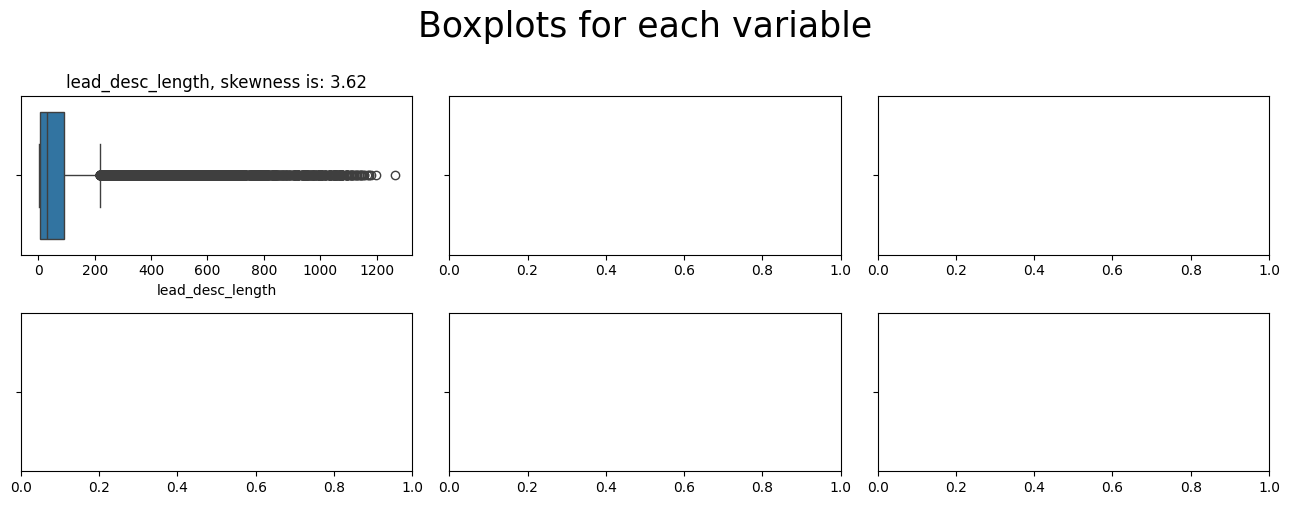

In [6]:
numerical_columns = [#'com_reg_ver_win_rate', 
                     #'historical_existing_cnt', 
    'lead_desc_length', 
    #'ver_win_rate_x', 
    #'ver_win_ratio_per_bu'
]
import seaborn as sns

# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(13,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df_train, columns_list=numerical_columns, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

In [7]:
from collections import Counter

def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [8]:
# detecting outliers
Outliers_IQR = IQR_method(df_train,1,numerical_columns)

# dropping outliers
df = df_train.drop(Outliers_IQR, axis = 0).reset_index(drop=True)
df_train=df

Total number of deleted outliers is: 5558


In [9]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [10]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    #"business_subarea",
    #"business_area",
    "business_unit",
    #"customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    #"product_subcategory",
    #"product_modelname",
    #"customer_country.1",
    "customer_position",
    "response_corporate",
    #"expected_timeline",
]

#df_train['business_area'] = df_train['business_area'].ffill()

mode_fill = df_train.groupby('lead_owner')['customer_country'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_train['customer_country'] = df_train['customer_country'].fillna(mode_fill)

mode_fill = df_test.groupby('lead_owner')['customer_country'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_test['customer_country'] = df_test['customer_country'].fillna(mode_fill)

mode_fill = df_train.groupby('customer_position')['inquiry_type'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_train['inquiry_type'] = df_train['inquiry_type'].fillna(mode_fill)

mode_fill = df_test.groupby('customer_position')['inquiry_type'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_test['inquiry_type'] = df_test['inquiry_type'].fillna(mode_fill)

mode_fill = df_train.groupby('customer_type')['inquiry_type'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_train['inquiry_type'] = df_train['inquiry_type'].fillna(mode_fill)

mode_fill = df_test.groupby('customer_type')['inquiry_type'].transform(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df_test['inquiry_type'] = df_test['inquiry_type'].fillna(mode_fill)



df_train.loc[df_train['business_unit'] == 'ID', 'id_strategic_ver'] = 1
df_train.loc[df_train['business_unit'] == 'IT', 'it_strategic_ver'] = 1
df_train.loc[(df_train['id_strategic_ver'] == 1) | (df_train['it_strategic_ver'] == 1), 'idit_strategic_ver'] = 1
df_train.fillna({'id_strategic_ver': 0, 'it_strategic_ver': 0, 'idit_strategic_ver':0 }, inplace=True)

df_test.loc[df_test['business_unit'] == 'ID', 'id_strategic_ver'] = 1
df_test.loc[df_test['business_unit'] == 'IT', 'it_strategic_ver'] = 1
df_test.loc[(df_test['id_strategic_ver'] == 1) | (df_test['it_strategic_ver'] == 1), 'idit_strategic_ver'] = 1
df_test.fillna({'id_strategic_ver': 0, 'it_strategic_ver': 0, 'idit_strategic_ver': 0}, inplace=True)

df_train.drop(columns='customer_type', inplace=True)
df_test.drop(columns='customer_type', inplace=True)

print(df_train.isna().sum()/len(df_train)) # 결손값 표시

df_train.head(30)

#df_train.to_csv('train_customer_country_filled.csv', index=False)
df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

bant_submit           0.000000
customer_country      0.000000
business_unit         0.000000
customer_idx          0.000000
enterprise            0.000000
id_strategic_ver      0.000000
it_strategic_ver      0.000000
idit_strategic_ver    0.000000
customer_job          0.315908
lead_desc_length      0.000000
inquiry_type          0.000135
product_category      0.326717
customer_position     0.000000
response_corporate    0.000000
ver_cus               0.000000
lead_owner            0.000000
is_converted          0.000000
dtype: float64


다시 학습 데이터와 제출 데이터를 분리합니다.

In [11]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [12]:
from imblearn.over_sampling import SMOTE

x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.3,
    shuffle=True,
    random_state=400,
)

# Instantiating SMOTE
smote = SMOTE(random_state=42)

# Performing oversampling only on the training data
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [13]:
## Scaling

In [14]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [15]:
col_names = numerical_columns
X_train = Standard_Scaler (x_train_resampled, col_names)
x_train_resampled=X_train
Y_test = Standard_Scaler (x_val, col_names)
x_val=Y_test

# Get the count of True and False values in y_train
true_count = (y_train == True).sum()
false_count = (y_train == False).sum()

print("Number of True values:", true_count)
print("Number of False values:", false_count)


Number of True values: 3392
Number of False values: 38117


## 3. 모델 학습

### 모델 정의 

In [16]:
from sklearn.ensemble import RandomForestClassifier

In [17]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

model=[]

#model.append(('ExtraTreesClassifier', ExtraTreesClassifier() ))
model.append(('RandomForest1', RandomForestClassifier() ))
model.append(('RandomForest2', RandomForestClassifier() ))
#model.append(('SVC', SVC(gamma ='auto', probability = True)))
#model.append(('AdaBoostClassifier', AdaBoostClassifier() ))
#model.append(('GradientBoostingClassifier', GradientBoostingClassifier() ))
model.append(('XGB1', XGBClassifier(max_depth=3, learning_rate=0.03, n_estimators=950, gamma=0.1, reg_alpha=1, reg_lambda=1) ))
model.append(('XGB2', XGBClassifier(max_depth=4, learning_rate=0.01, n_estimators=950, gamma=0.1, reg_alpha=1, reg_lambda=1) ))
model.append(('XGB3', XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=950, gamma=0.1, reg_alpha=1, reg_lambda=1) ))
model.append(('XGB4', XGBClassifier(max_depth=4, learning_rate=0.03, n_estimators=950, gamma=0.1, reg_alpha=1, reg_lambda=1) ))
#model.append(('CatBoost', CatBoostClassifier(logging_level='Silent') ))


### 모델 학습

In [18]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.model_selection import cross_validate
    
# Create a voting classifier with the XGBoost models
voting_clf = VotingClassifier(estimators = model, voting ='soft')

# Fit the voting classifier on the entire training data
#voting_clf.fit(x_train_resampled, y_train_resampled)

# Define cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_voting_clf = None

print(x_train_resampled.index)
print(y_train_resampled.index)

for train_index, val_index in skf.split(x_train_resampled, y_train_resampled):
    num_rows_x_train, num_cols_x_train = x_train_resampled.shape
    print("Number of rows in x_train_resampled:", num_rows_x_train)
    print("Number of rows in y_train_resampled:", len(y_train_resampled))
    
    print("Train Index Size:", len(train_index))
    print("Validation Index Size:", len(val_index))
       # Extract train and validation folds using row indices
    x_train_fold, x_val_fold = x_train_resampled.iloc[train_index], x_train_resampled.iloc[val_index]
    y_train_fold, y_val_fold = y_train_resampled.iloc[train_index], y_train_resampled.iloc[val_index]
    
    # Train the voting classifier
    voting_clf.fit(x_train_fold, y_train_fold)
    
    # Validate
    val_pred = voting_clf.predict(x_val_fold)
    val_accuracy = accuracy_score(y_val_fold, val_pred)
    print("trained once")
    # Check for improvement in validation accuracy
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_voting_clf = voting_clf
    else:
        # If validation accuracy doesn't improve much, stop training
        break


RangeIndex(start=0, stop=76234, step=1)
RangeIndex(start=0, stop=76234, step=1)
Number of rows in x_train_resampled: 76234
Number of rows in y_train_resampled: 76234
Train Index Size: 60987
Validation Index Size: 15247
trained once
Number of rows in x_train_resampled: 76234
Number of rows in y_train_resampled: 76234
Train Index Size: 60987
Validation Index Size: 15247
trained once
Number of rows in x_train_resampled: 76234
Number of rows in y_train_resampled: 76234
Train Index Size: 60987
Validation Index Size: 15247
trained once


### 모델 성능 보기

In [19]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

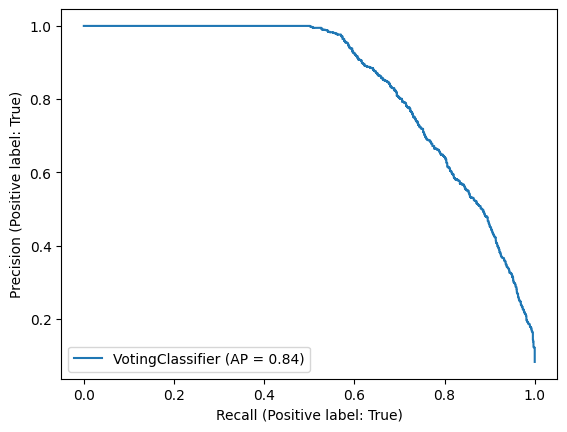

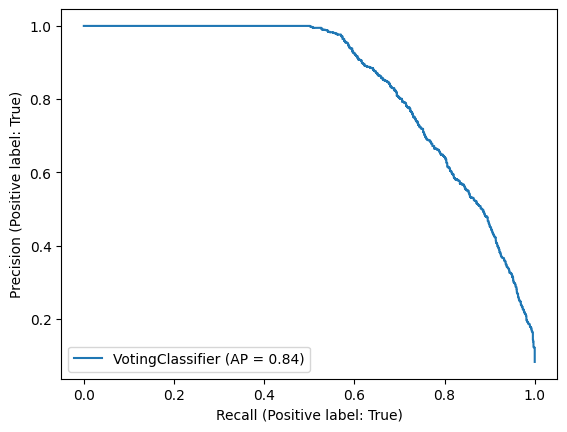

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

# Create Precision-Recall curve display
precision_recall_display = PrecisionRecallDisplay.from_estimator(voting_clf, x_val, y_val)

# Plot the precision-recall curve
precision_recall_display.plot()

# Show the plot
plt.show()

In [37]:
test_pred = voting_clf.predict(x_val.fillna(0))
pred_proba = voting_clf.predict_proba(x_val.fillna(0))[:, 1]

# 임계값 조정을 통한 예측
threshold = 0.5  # 임계값 초기값
while sum(pred_proba > threshold) < 2000:
    threshold -= 0.01  # 임계값을 0.01씩 감소시킴
test_pred = (pred_proba > threshold).astype(int)
get_clf_eval(y_val, test_pred)
print(threshold)

오차행렬:
 [[ 1196   262]
 [  838 15494]]

정확도: 0.9382
정밀도: 0.5880
재현율: 0.8203
F1: 0.6850
0.34999999999999987


## 4. 제출하기

### 테스트 데이터 예측

In [38]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [39]:
#test_pred = best_model.predict(x_test.fillna(0))
#test_pred = best_tree.predict(x_test.fillna(0))
pred_proba = voting_clf.predict_proba(x_test.fillna(0))[:, 1]
test_pred = (pred_proba > threshold).astype(int)
test_pred_size = test_pred.shape
print("Size of test_pred array:", test_pred_size)
sum(test_pred) # True로 예측된 개수

Size of test_pred array: (5271,)


1649

### 제출 파일 작성

In [40]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**